In [5]:
#import libraries

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

Part A

In [6]:
def prostate_segmenter(img, lower_thresh, upper_thresh, seed_point):
    '''This function Performs Median Smoothing and Connected Threshold Image Filter Segmentation.
    param img: The image object to be processed
    param lower_thresh: the lower threshold intensity for the Connected Threshold Image Filter
    param upper_thresh: the upper threshold intensity for the Connected Threshold Image Filter
    param seed_point: a list of tupule coordinates in ikj which Connected Threshold Image Filter takes as seeds
    return seg: the segmented image object'''
    
    #first, smoothen image using MedianImageFilter()
    median_filter = sitk.MedianImageFilter()
    median_filter.SetRadius(2)
    img_smooth = median_filter.Execute(img)
    
    #perform Connected Threshold Image Filter Segmentation    
    cti_filter = sitk.ConnectedThresholdImageFilter()
    
    cti_filter.SetLower(lower_thresh)
    cti_filter.SetUpper(upper_thresh)
    cti_filter.SetSeedList(seed_point)
    
    seg = cti_filter.Execute(img_smooth)
    
    return seg

In [7]:
def resample_to_reference(input_image, reference_image):
#https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/55_VH_Resample.ipynb
#https://www.programcreek.com/python/example/96383/SimpleITK.sitkNearestNeighbor
    '''This function resamples an image to match the spacing of a reference image. Note: for the purpose of this assignment,
    it was created as the gold standard mask and the MRI image do not have the same spacing, which they must in order to
    later plot an overlay.
    param input_image: the image object to be resampled
    param reference_image: the reference image with the desired spacing
    return resampled_image: the resampled input image
    '''
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference_image)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetTransform(sitk.Transform())
    resampled_image = resampler.Execute(input_image)
    
    return resampled_image

In [8]:
def plot_overlay(img, seg, gs_mask):
    '''This function creates 2 overlay plots; both with the same base, but two separate overlays. For the purpose of this
    assignment, an MRI image object is the basis of both plots. The first plot includes an overlay from CTIF segmentation.
    The second plot includes a gold standard prostate overlay.
    param img: the image object included in both plots
    param seg: the basis image object
    param seg: the first overlay object
    param gs_mask: the second overlay object'''
    
    overlay_image = sitk.LabelOverlay(img, seg)
    overlay_array = sitk.GetArrayViewFromImage(overlay_image)[13,:,:]
    
    gs_overlay_image = sitk.LabelOverlay(img, gs_mask)
    gs_overlay_array = sitk.GetArrayViewFromImage(gs_overlay_image)[13,:,:]
    
    plt.subplot(1,2,1)
    plt.title('Region Growing Segmentation')
    plt.imshow(overlay_array, cmap='gray')
    
    plt.subplot(1,2,2)
    plt.title('Gold Standard Segmentation')
    plt.imshow(gs_overlay_array, cmap='gray')
        
    plt.show()

Part B

In [9]:
def seg_eval_dice(seg, gs_res):
#https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1LabelOverlapMeasuresImageFilter.html
    '''This function takes two image objects and calculates their DICE similarity score.
    param seg: the first image object
    param gs_res: the second image object
    return dsc_coef: the DICE coefficient'''
    
    dsc = sitk.LabelOverlapMeasuresImageFilter()
    dsc.Execute(seg, gs_res)
    dsc_coef = dsc.GetDiceCoefficient()
    return dsc_coef

Part C

In [13]:
 def pixel_extract(img, point, width):
    '''This function plots pixel intensity of a particular region inside a greater image.
    param img: the greater image object
    param point: LPS coordinates in mm to the point of interest
    width: the width of the region of interest'''
    
    #get origin and spacing in mm
    spacing = img.GetSpacing()
    origin = img.GetOrigin()
    
    #calculate pixel width
    pixel_width = [width / s for s in spacing]
    
    #LPS points and spacing --> array
    lps_point = np.array(point)
    spacing_array = np.array(spacing)
    
    #LPS coordinates --> rounded voxel coordinates
    #set image point as center
    image_point = (lps_point - np.array(origin)) / spacing_array
    center = np.round(image_point).astpye(int)
    
    #calculate cube boundaries
    half_width = np.round(np.array(width_pixels) / 2).astype(int)
    start = np.maximum(center - half_width, [0, 0, 0])
    end = np.minimum(center + half_width, np.array(img.GetSize()) - 1)
    
    #define cube
    cube = img[start[0]:end[0]+1, start[1]:end[1]+1, start[2]:end[2]+1]
    
    #get intensity values
    cube_array = sitk.GetArrayFromImage(cube)
    intensity_values = cube_array.flatten()
    
    #plot
    plt.figure(figsize=(8,6))
    plt.boxplot(intensity_values, vert=True)
    plt.xlabel(f'{point}')
    plt.ylabel('pixel intensity')
    plt.title(f'Boxplot of Intensity Values around Target ({point})')
    plt.show()
    

Main

In [14]:
def main():
    #read in external files
    gs_mask = sitk.ReadImage("10522_1000532_segmentation.nii")
    img = sitk.ReadImage("10522_1000532_t2wMRI.mha")
    
    #resample gs mask to match mri
    gs_res = resample_to_reference(gs_mask, img)
    
    #perform region growing with fine tuned parameters
    seed_point = [(452,5489,13),(578,523,13),(518,452,13)]
    lower_thresh = 50
    upper_thresh = 150
    seg = prostate_segmenter(img, lower_thresh, upper_thresh, seed_point)
    
    #save segmentation - do this when everything is finalized
    #sitk.WriteImage(seg, 'my_segmentation.nrrd')
    
    plot_overlay(img, seg, gs_res)
    
    #get dice coefficient
    dsc_coef = seg_eval_dice(seg, gs_res)
    print(f"The dice coefficient is:{dsc_coef}")
    
    #extract pixel
    point = (5, 25, 30)
    width = 5
    pixel_extract(img, point, width)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


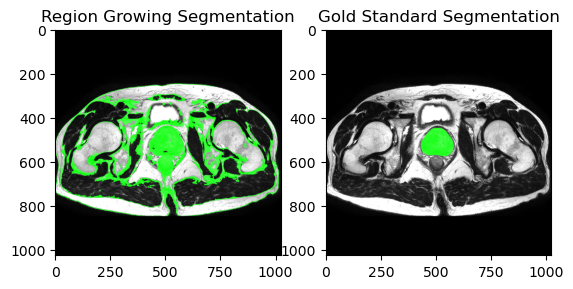

The dice coefficient is:0.09124901027296996


TypeError: only length-1 arrays can be converted to Python scalars

In [12]:
main()

In [1]:
pwd()

'C:\\Users\\julia\\BMIF 804'